In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    for i in range(len(gpu_devices)):
        tf.config.experimental.set_memory_growth(gpu_devices[i], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload

import datetime as dt
import pandas as pd
os.chdir("../from_config") ######!!!!!!
import dev.datawhere as dl
graph_data=dl.graph_data

Notebook
GPU detected


In [2]:
os.chdir('../model_eval')
os.getcwd()

'C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor\\IceCube\\model_eval'

In [3]:
def get_sets():
        print('Reading sets')
        sets = pd.read_pickle('../db_files/dev_lvl7/sets.pkl')
        train_events = sets['train']
        test_events = sets['test']
        return train_events['event_no'].to_numpy(), test_events['event_no'].to_numpy()
_, test_events=get_sets()

Reading sets


In [4]:
# dfjv=pd.read_csv('../predictions/OscNext_ZeE_m27_3f6o_test_predictions.csv').sort_values(by='event_no')

dfjv=pd.read_csv('../predictions/OscNext_EAngle_m27_2kql_test_predictions.csv').sort_values(by='event_no')

dfckj=pd.read_csv('../predictions/ckj_2dvM_1306_final.csv').sort_values(by='event_no')
dfjs=pd.read_csv('../predictions/jakob_predictions_0106_2.csv').sort_values(by='event_no')
dfjbs=pd.read_csv('../predictions/current_best_predictions.csv').sort_values(by='event_no')
# dfjbs=pd.read_csv('../predictions/GraphSageFullOscNext_3D.csv')
dfstats=pd.read_csv('../predictions/stats.csv').sort_values(by='event_no')

In [643]:
dfjs.rename(columns={'zenith_pred_sigma': 'zenith_kap'}, inplace=True)
dfckj.rename(columns={'zenith_kappa': 'azimuth_kap'}, inplace=True)
dfckj.rename(columns={'azimuth_kappa': 'zenith_kap'}, inplace=True)
dfjs=dfjs.drop(0)

In [644]:
dfjv=dfjv.reset_index(drop=True)
dfckj=dfckj.reset_index(drop=True)
dfjs=dfjs.reset_index(drop=True)
dfjbs=dfjbs.reset_index(drop=True)
# dfjbs=pd.read_csv('../predictions/GraphSageFullOscNext_3D.csv')
dfstats=dfstats.reset_index(drop=True)

In [645]:
a=np.sum(dfjbs['event_no']==dfjv['event_no'])-1658362
b=np.sum(dfjbs['event_no']==dfjs['event_no'])-1658362
c=np.sum(dfjbs['event_no']==dfckj['event_no'])-1658362
a,b,c

(0, 0, 0)

In [646]:
# co='energy_log10'
co='zenith'
dfjv['zenith']=dfckj['zenith']
a=np.sum(np.isclose(dfjbs[co],dfjv[co], rtol=1e-3))-1658362
b=np.sum(np.isclose(dfjbs[co],dfckj[co], rtol=1e-3))-1658362
c=np.sum(np.isclose(dfjbs[co],dfjs[co], rtol=1e-3))-1658362
a,b,c

(-2, -2, -2)

In [647]:
co='energy_log10'
# co='zenith'
dfjv[co]=dfckj[co]
a=np.sum(np.isclose(dfjv[co],dfjbs[co], rtol=1e-3))-1658362
b=np.sum(np.isclose(dfjv[co],dfckj[co], rtol=1e-3))-1658362
c=np.sum(np.isclose(dfjv[co],dfjs[co], rtol=1e-3))-1658362
a,b,c

(0, 0, 0)

In [648]:
# co='energy_log10'
co='zenith'

a=np.sum(np.isclose(dfjs[co],dfjv[co], rtol=1e-3))-1658362
b=np.sum(np.isclose(dfjs[co],dfckj[co], rtol=1e-3))-1658362
c=np.sum(np.isclose(dfjs[co],dfjbs[co], rtol=1e-3))-1658362
a,b,c

(0, 0, -2)

In [649]:
dfs=[dfjv, dfckj, dfjs, dfjbs]
names=['Jonas', 'Christian', 'Schauser', 'Johann']
predl=['energy_log10_pred', 'zenith_pred', 'azimuth_pred', 'zenith_kappa', 'azimuth_kappa']
truel=['energy_log10', 'zenith', 'azimuth', 'event_no']

colors=['#F7996E', '#20A4F3', '#519872', '#712F79', 'k', 'r']

In [650]:
for df in dfs:
    for target in truel[:3]:
        if target not in df.columns:
            df[target]=dfs0[3][target].to_numpy()
        if target+'_pred' in df.columns:
            df[target+'_res']=df[target]-df[target+'_pred']

In [651]:
for df in dfs:
    print(df.columns)

Index(['Unnamed: 0', 'event_no', 'energy_log10', 'azimuth', 'zenith', 'x', 'y',
       'z', 'energy_log10_pred', 'solid_angle', 'azimuth_pred', 'zenith_pred',
       'x_pred', 'y_pred', 'z_pred', 'energy_log10_sig', 'x_sig', 'y_sig',
       'z_sig', 'solid_angle_sig', 'azimuth_sig', 'zenith_sig',
       'energy_log10_res', 'zenith_res', 'azimuth_res'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'energy_log10', 'zenith', 'azimuth',
       'event_no', 'energy_log10_pred', 'zenith_pred', 'azimuth_pred',
       'azimuth_kap', 'zenith_kap', 'energy_log10_res', 'zenith_res',
       'azimuth_res'],
      dtype='object')
Index(['Unnamed: 0', 'event_no', 'energy_log10', 'energy_log10_pred', 'zenith',
       'zenith_pred', 'zenith_kap', 'energy_log10_res', 'zenith_res',
       'azimuth'],
      dtype='object')
Index(['Unnamed: 0', 'event_no', 'zenith', 'zenith_pred', 'zenith_kap',
       'energy_log10', 'energy_log10_pred', 'energy_log10_sig', 'azimuth',
       'azimuth_pred', 'a

In [652]:
import sqlite3, os, sys, pickle
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
transform_path='../db_files/dev_lvl7/transformers.pkl'
db_path= '../db_files/dev_lvl7/dev_lvl7_mu_nu_e_classification_v003.db'
conn = sqlite3.connect(db_path)
def get_event_no():
        print('Reading sets')
        sets = pd.read_pickle('../db_files/dev_lvl7/sets.pkl')
        train_events = sets['train']
        test_events = sets['test']
        return train_events['event_no'].to_numpy(), test_events['event_no'].to_numpy()
_, test_events=get_event_no()
df_truth=pd.read_sql(f"select * from truth where event_no in {tuple(test_events)}", conn).sort_values(by='event_no')
cols=df_truth.columns

Reading sets


In [653]:
transformers = pickle.load(open(transform_path, 'rb'))
trans_y      = transformers['truth']

for col in trans_y.keys():
    df_truth[col] = trans_y[col].inverse_transform(np.array(df_truth[col]).reshape(1, -1)).T

In [654]:
for col in cols:
    if 'position' in col:
        df_truth.drop(col, axis=1, inplace=True)

In [655]:
new=['event_no', 'energy_log10', 'azimuth', 'zenith', 'azimuth_pred', 'energy_log10_pred',
       'zenith_pred', 'azimuth_sig', 'zenith_sig', 'energy_log10_sig']
sel=['event_no', 'energy_log10', 'azimuth', 'zenith',  'azimuth_retro', 'energy_log10_retro',
       'zenith_retro', 'azimuth_sigma', 'zenith_sigma', 'energy_log10_sigma']

In [656]:
dfretro=pd.DataFrame(df_truth[sel].to_numpy(), columns=new)
for target in truel[:3]:
    if target+'_pred' in df.columns:
        dfretro[target+'_res']=dfretro[target]-dfretro[target+'_pred']
dfs.append(dfretro)

In [657]:
names.append('Retro')

In [658]:
from scipy.special import iv

def approx(x):
    x=np.array(x)
    a=1-3/(8*x)
    b=1+1/(8*x)
    return a/b

def kap_to_sig(kappa):
#     kappa =  kappa**2 + 1e-100
    kappa =  kappa + 1e-100
    sigs=np.where(kappa>700, np.sqrt(abs(np.sqrt(-2*np.log(approx(kappa))))), np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))))
    return sigs**2

sigs=kap_to_sig(np.arange(0,100,20))

<ipython-input-658-03d4a62b141e>:12: RuntimeWarning: invalid value encountered in log
  sigs=np.where(kappa>700, np.sqrt(abs(np.sqrt(-2*np.log(approx(kappa))))), np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))))


In [659]:
sigs

array([21.491936  ,  0.22652066,  0.15912234,  0.12964462,  0.1121563 ])

In [660]:
for name,df in zip(names, dfs):
    for target in truel:
        if target+'_kap' in df.columns:
                df[target+'_sig']=kap_to_sig(df[target+'_kap'].to_numpy())

<ipython-input-658-03d4a62b141e>:12: RuntimeWarning: invalid value encountered in log
  sigs=np.where(kappa>700, np.sqrt(abs(np.sqrt(-2*np.log(approx(kappa))))), np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))))


In [661]:
for df in dfs:
    print(df.columns)

Index(['Unnamed: 0', 'event_no', 'energy_log10', 'azimuth', 'zenith', 'x', 'y',
       'z', 'energy_log10_pred', 'solid_angle', 'azimuth_pred', 'zenith_pred',
       'x_pred', 'y_pred', 'z_pred', 'energy_log10_sig', 'x_sig', 'y_sig',
       'z_sig', 'solid_angle_sig', 'azimuth_sig', 'zenith_sig',
       'energy_log10_res', 'zenith_res', 'azimuth_res'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'energy_log10', 'zenith', 'azimuth',
       'event_no', 'energy_log10_pred', 'zenith_pred', 'azimuth_pred',
       'azimuth_kap', 'zenith_kap', 'energy_log10_res', 'zenith_res',
       'azimuth_res', 'zenith_sig', 'azimuth_sig'],
      dtype='object')
Index(['Unnamed: 0', 'event_no', 'energy_log10', 'energy_log10_pred', 'zenith',
       'zenith_pred', 'zenith_kap', 'energy_log10_res', 'zenith_res',
       'azimuth', 'zenith_sig'],
      dtype='object')
Index(['Unnamed: 0', 'event_no', 'zenith', 'zenith_pred', 'zenith_kap',
       'energy_log10', 'energy_log10_pred', 'energy_log10

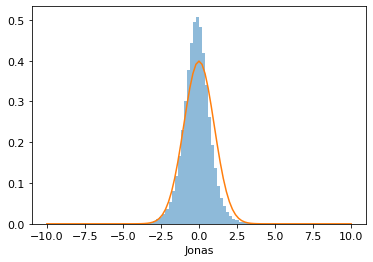

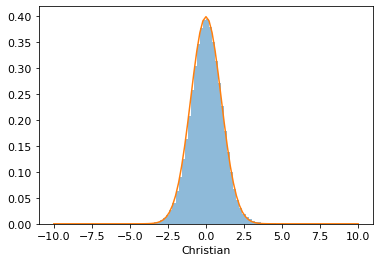

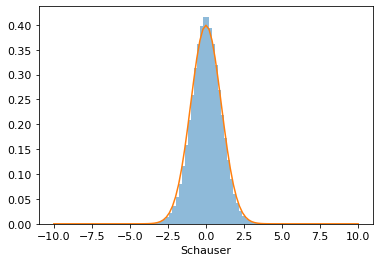

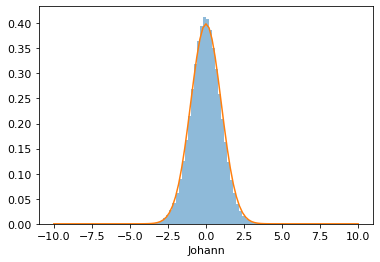

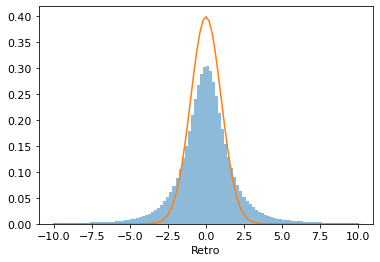

In [663]:
from scipy.stats import norm
for k in range(5):
    fig, ax =plt.subplots()
    _, bins, _ = ax.hist(dfs[k].zenith_res/(dfs[k].zenith_sig), bins=100, range=(-10,10), density=1, alpha=0.5)
    ax.plot(bins, norm.pdf(bins,0,1))
    ax.set(xlabel=names[k])

In [664]:
model_names=['GGConv', 'StateFarm', 'LifeGuard', 'AntHills', 'Retro']

[1.46257556 5.56049952 9.13522424]
[ 2.17132397  8.63144895 14.16573065]
[ 2.76207994 11.1577918  18.23735176]
[ 3.30802124 13.48925965 21.98160109]
[ 3.86581835 15.93756569 26.05276453]
[1.50179417 5.30395503 8.40581959]
[ 2.03081458  7.38128331 11.77835814]
[ 2.42912071  8.96060942 14.2316784 ]
[ 2.78519482 10.38918694 16.46477962]
[ 3.15741087 11.92369027 19.01342088]
[ 3.14635658 10.53354111 15.58559921]
[ 3.58219912 12.05520791 17.9727921 ]
[ 3.93316391 13.32416892 19.9889924 ]
[ 4.28483834 14.58980716 22.02415077]
[ 4.65513974 15.93490123 24.20946539]
[ 2.32232253  8.03081137 12.25847763]
[ 2.84063903  9.85373389 15.08919911]
[ 3.24426245 11.30103101 17.32821401]
[ 3.60963503 12.6633413  19.49675591]
[ 4.01032527 14.19873985 22.02838459]
[ 1.46592748  6.657685   12.44245361]
[ 2.18204641  9.73462833 17.1101087 ]
[ 2.70925992 11.75742677 20.00648456]
[ 3.15212456 13.39086577 22.31688868]
[ 3.57526787 15.00208825 24.75184649]


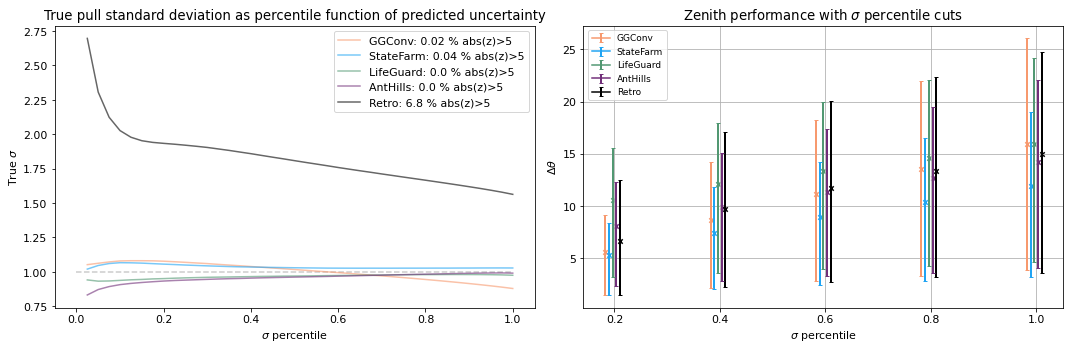

In [666]:
import matplotlib
font = {'size'   : 11}

matplotlib.rc('font', **font)
fig, ax=plt.subplot_mosaic(layout=
"""
0000011111
""", figsize=(15,5))

bins=5
off=0.007
for i, df in enumerate(dfs):
    for j in range(bins):
        resi=np.percentile(np.abs(df[(df['zenith_sig'] < np.percentile(df['zenith_sig'], 100/bins*(j+1)))].zenith_res)*180/np.pi,[16,50,68])
        print(resi)
        ax['1'].scatter((j+1)/bins+off*(i-2.5), resi[1], color=colors[i], marker='x', s=20, ls="None")
        if j+1==bins:
            ax['1'].errorbar((j+1)/bins+off*(i-2.5), resi[1], s=None, capsize=2, marker=None, elinewidth=2, yerr=np.vstack([[resi[1]-resi[0]],[resi[2]-resi[1]]]), color=colors[i], label=model_names[i])
        else:
            ax['1'].errorbar((j+1)/bins+off*(i-2.5), resi[1], s=None, capsize=2, marker=None, elinewidth=2, yerr=np.vstack([[resi[1]-resi[0]],[resi[2]-resi[1]]]), color=colors[i])
ax['1'].legend(fontsize=9)  
ax['1'].grid(True)
ax['1'].set(xlabel=r'$\sigma$ percentile', ylabel=r'$\Delta \theta$', title=r'Zenith performance with $\sigma$ percentile cuts')

k=40
for i, df in enumerate(dfs):
    sig_run=[]
    for j in range(1,k+1):
        df_per=df[(df['zenith_sig'] < np.percentile(df['zenith_sig'], j*100/k))]
        if j==k:
            a=len(df_per)
        df_per=df_per[abs(df_per['zenith_res']/(df_per['zenith_sig']+0.000001))<5]
        if j==k:
            b=len(df_per)
            c=a-b
        st=np.std(df_per['zenith_res']/(df_per['zenith_sig']+0.000001))
#         print(st)
        sig_run.append(st)
    
    ax[str(0)].plot(np.arange(1,k+1)/k, sig_run, label=model_names[i]+f': {np.round(c/a*100, 2)} % abs(z)>5', c=colors[i],  linestyle='-', alpha=0.6)
ax[str(0)].set(xlabel=r'$\sigma$ percentile', ylabel=r'True $\sigma$', title='True pull standard deviation as percentile function of predicted uncertainty')
ax[str(0)].hlines(1,0,1, linestyle='dashed', alpha=0.4, color='gray')
ax[str(0)].legend()

fig.tight_layout()

In [667]:
fig.savefig('../../figs_thesis/zenith_sig_performance_neutrino_small.pdf')

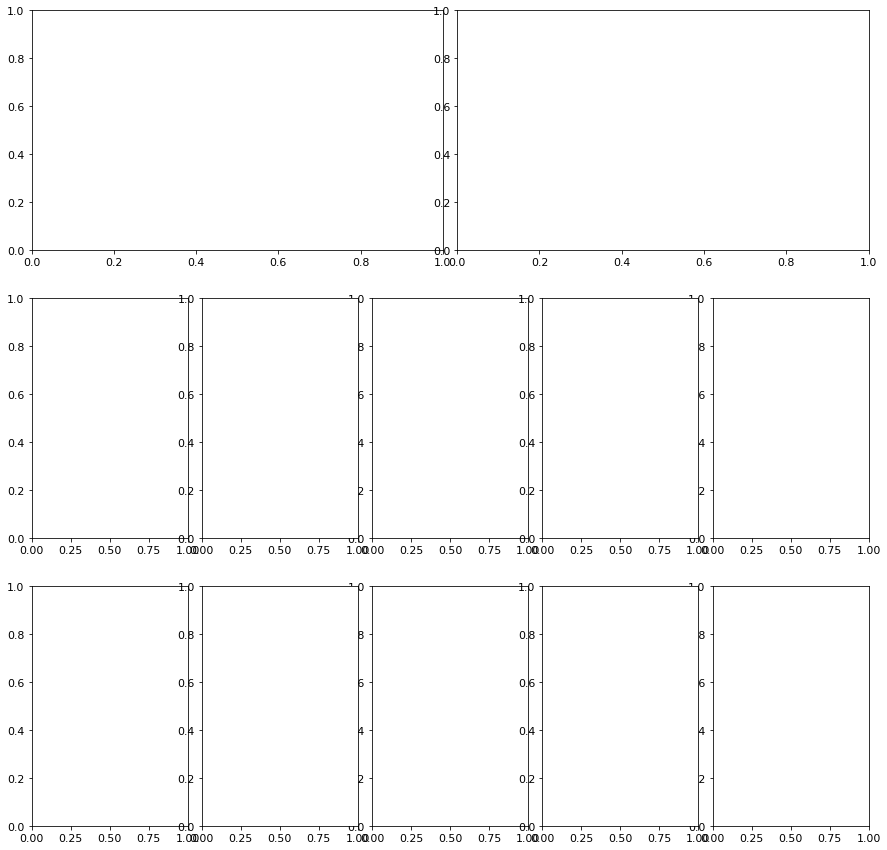

In [669]:
import matplotlib
font = {'size'   : 11}

matplotlib.rc('font', **font)
fig, ax=plt.subplot_mosaic(layout=
"""
0000011111
2233445566
aabbccddee
""", figsize=(15,15))

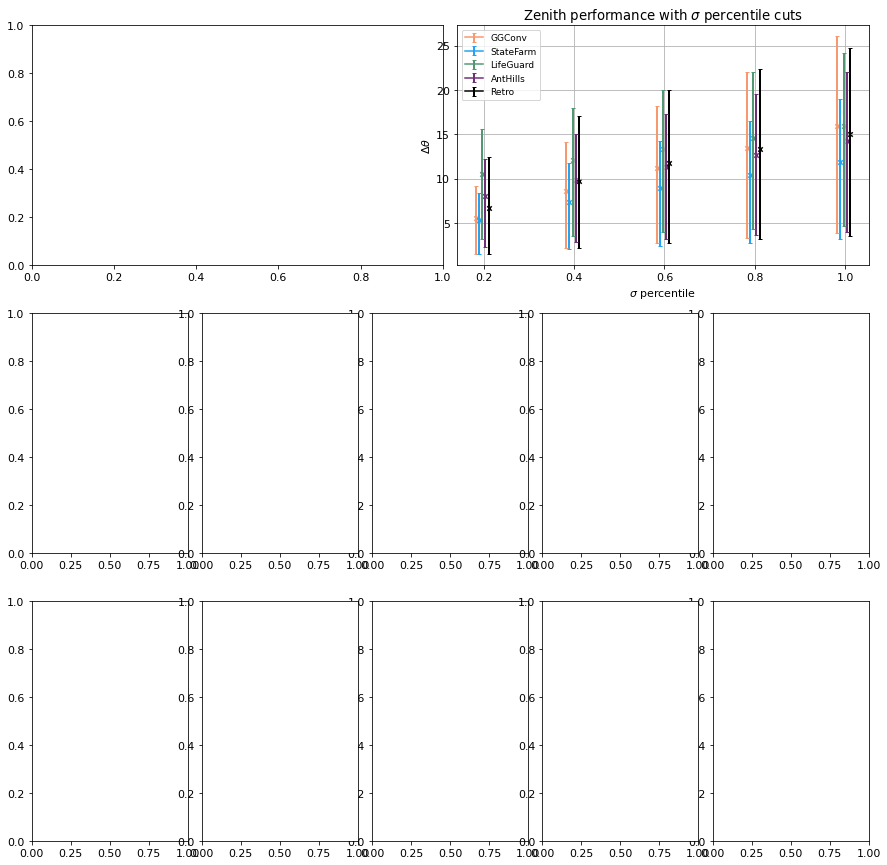

In [670]:
bins=5
off=0.007
for i, df in enumerate(dfs):
    for j in range(bins):
        resi=np.percentile(np.abs(df[(df['zenith_sig'] < np.percentile(df['zenith_sig'], 100/bins*(j+1)))].zenith_res)*180/np.pi,[16,50,68])
        ax['1'].scatter((j+1)/bins+off*(i-2.5), resi[1], color=colors[i], marker='x', s=20, ls="None")
        if j+1==bins:
            ax['1'].errorbar((j+1)/bins+off*(i-2.5), resi[1], s=None, capsize=2, marker=None, elinewidth=2, yerr=np.vstack([[resi[1]-resi[0]],[resi[2]-resi[1]]]), color=colors[i], label=model_names[i])
        else:
            ax['1'].errorbar((j+1)/bins+off*(i-2.5), resi[1], s=None, capsize=2, marker=None, elinewidth=2, yerr=np.vstack([[resi[1]-resi[0]],[resi[2]-resi[1]]]), color=colors[i])
ax['1'].legend(fontsize=9)  
ax['1'].grid(True)
ax['1'].set(xlabel=r'$\sigma$ percentile', ylabel=r'$\Delta \theta$', title=r'Zenith performance with $\sigma$ percentile cuts')
fig

In [671]:
for k in range(5):
    _, bins, _ = ax[str(k+2)].hist(dfs[k].zenith_res/(dfs[k].zenith_sig), bins=100, range=(-10,10), density=1, alpha=0.5, color=colors[k])
    ax[str(k+2)].plot(bins, norm.pdf(bins,0,1), c='r')
    ax[str(k+2)].set(xlabel=model_names[k]+r' $\theta$ pull scores')
    if k!=0:
        ax[str(k+2)].axes.get_yaxis().set_visible(False)
    else:
        ax[str(k+2)].set(ylabel='Probability density')
ax['4'].set(title='Normalized pull plots compared with unit gaussians')

[Text(0.5, 1.0, 'Normalized pull plots compared with unit gaussians')]

In [672]:
k=40
for i, df in enumerate(dfs):
    sig_run=[]
    for j in range(1,k+1):
        df_per=df[(df['zenith_sig'] < np.percentile(df['zenith_sig'], j*100/k))]
        if j==k:
            a=len(df_per)
        df_per=df_per[abs(df_per['zenith_res']/(df_per['zenith_sig']+0.000001))<5]
        if j==k:
            b=len(df_per)
            c=a-b
        st=np.std(df_per['zenith_res']/(df_per['zenith_sig']+0.000001))
#         print(st)
        sig_run.append(st)
    
    ax[str(0)].plot(np.arange(1,k+1)/k, sig_run, label=model_names[i]+f': {np.round(c/a*100, 2)} % abs(z)>5', c=colors[i],  linestyle='-', alpha=0.6)
ax[str(0)].set(xlabel=r'$\sigma$ percentile', ylabel=r'True $\sigma$', title='True pull standard deviation as percentile function of predicted uncertainty')
ax[str(0)].hlines(1,0,1, linestyle='dashed', alpha=0.4, color='gray')
ax[str(0)].legend()

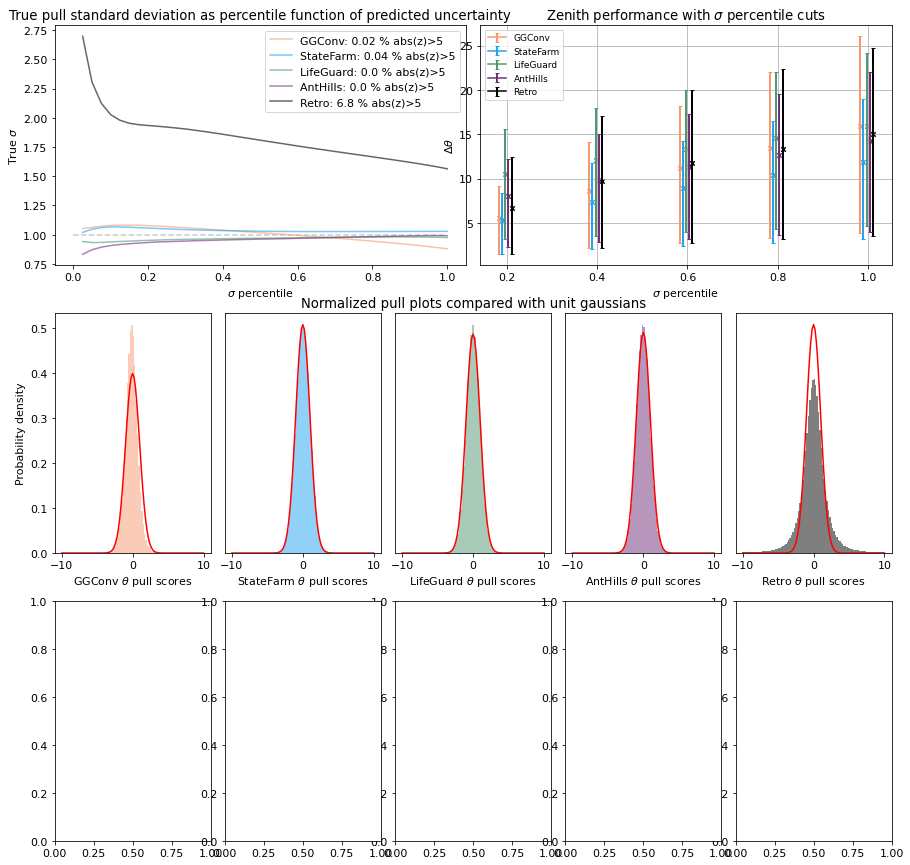

In [673]:
fig

In [674]:
axns=['a','b','c','d','e']
n=0
p=100
for axn, df in zip(axns, dfs):
    ax[axn].hist2d(df[(df['zenith_sig'] < np.percentile(df['zenith_sig'], p))].zenith_sig*180/np.pi,
                    df[(df['zenith_sig'] < np.percentile(df['zenith_sig'], p))].zenith_res*180/np.pi,\
              bins=100, range=[[0,50], [-70,70]]);
    ax[axn].set(xlabel=r'$\sigma_{pred}$'+f' ({model_names[n]})')
    if n!=0:
        ax[axn].axes.get_yaxis().set_visible(False)
    else:
        ax[axn].set(ylabel='Zenith residual (degrees)')
    n+=1
ax['c'].set(title=r'Residual-$\sigma_{pred}$ correlations')

[Text(0.5, 1.0, 'Residual-$\\sigma_{pred}$ correlations')]

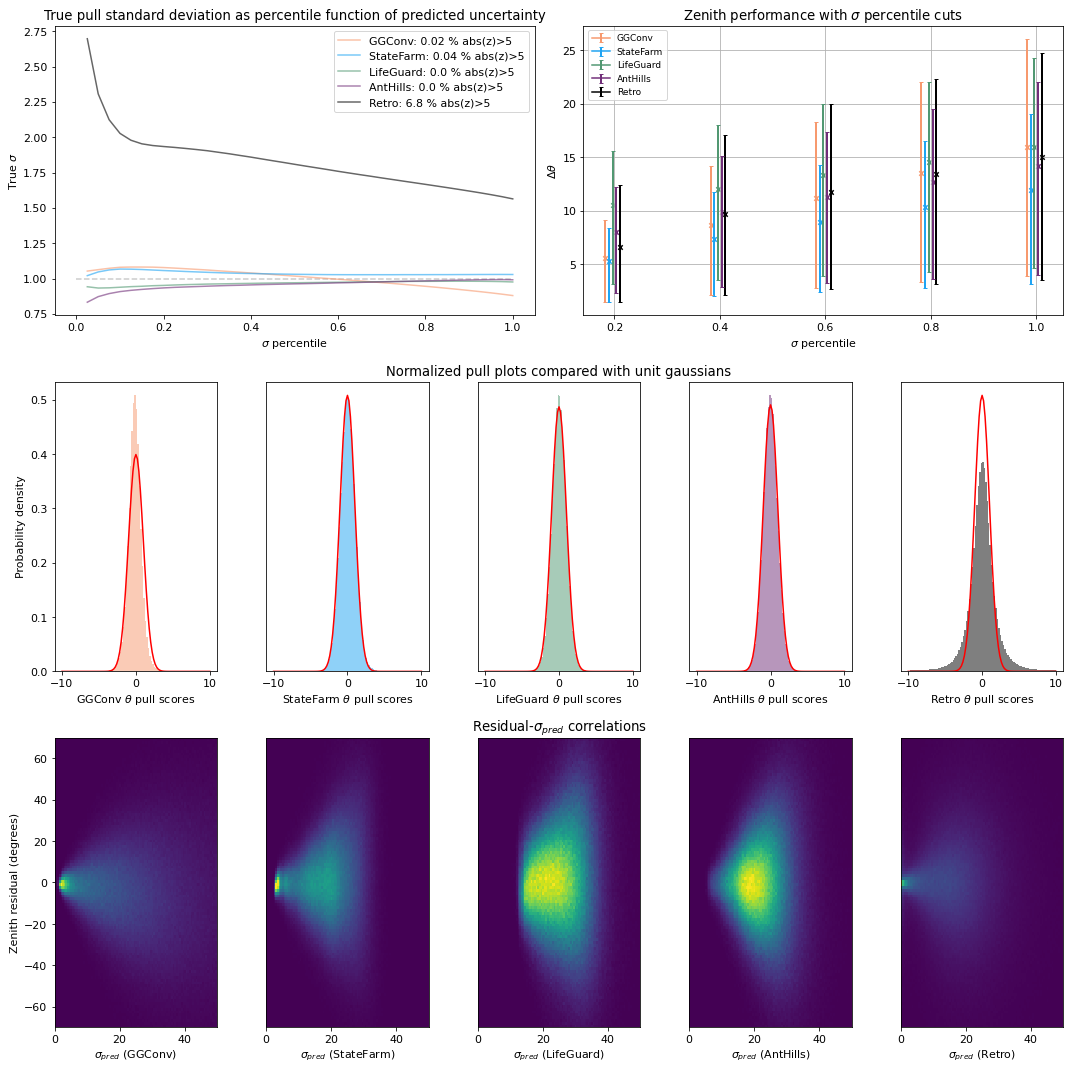

In [675]:
# fig.suptitle('Zenith uncertainty analysis', fontsize=18, y=-0.013, va='bottom')
fig.tight_layout()
fig

In [676]:
fig.savefig('../../figs_thesis/zenith_sig_performance_neutrino_full.pdf')

In [402]:
np.sum(dfjv['zenith_sig']*180/np.pi<10)/len(dfjv['zenith_sig'])

0.10729080864129786

In [459]:
np.percentile(abs(dfckj['azimuth_res'])*180/np.pi, 50)

33.734802665841116

In [370]:
def perms(val):
    perm=[]
    for i in range(val):
        for j in range(i, val):
            if i!=j:
                perm.append(np.array([i,j]))
    return np.array(perm)

In [371]:
def corr_plot(dfs, param, names=names, lim=2, basesize=5, bins=200, nr=2, nc=3):
    fig, ax =plt.subplots(nrows=nr, ncols=nc, figsize=(basesize*nc,basesize*nr))
    perm=perms(len(dfs))
    if len(perm)!=nr*nc:
        print(f"Ax doesn't fit dataframe, supposed to be {len(perm)} in total")
    k=0
    for i in range(nr):
        for j in range(nc):
            p=perm[k]
            ax[i][j].hist2d(dfs[p[0]][param+'_res'], dfs[p[1]][param+'_res'], range=[[-lim,lim],[-lim,lim]], bins=bins)
            ax[i][j].set(xlabel=names[p[0]], ylabel=names[p[1]])
            k+=1
    fig.suptitle(f"Comparison of {param}")
    fig.tight_layout()
    return fig, ax

(<Figure size 1440x576 with 10 Axes>,
 array([[<AxesSubplot:xlabel='Jonas', ylabel='Christian'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Schauser'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Johann'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Retro'>,
         <AxesSubplot:xlabel='Christian', ylabel='Schauser'>],
        [<AxesSubplot:xlabel='Christian', ylabel='Johann'>,
         <AxesSubplot:xlabel='Christian', ylabel='Retro'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Johann'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Retro'>,
         <AxesSubplot:xlabel='Johann', ylabel='Retro'>]], dtype=object))

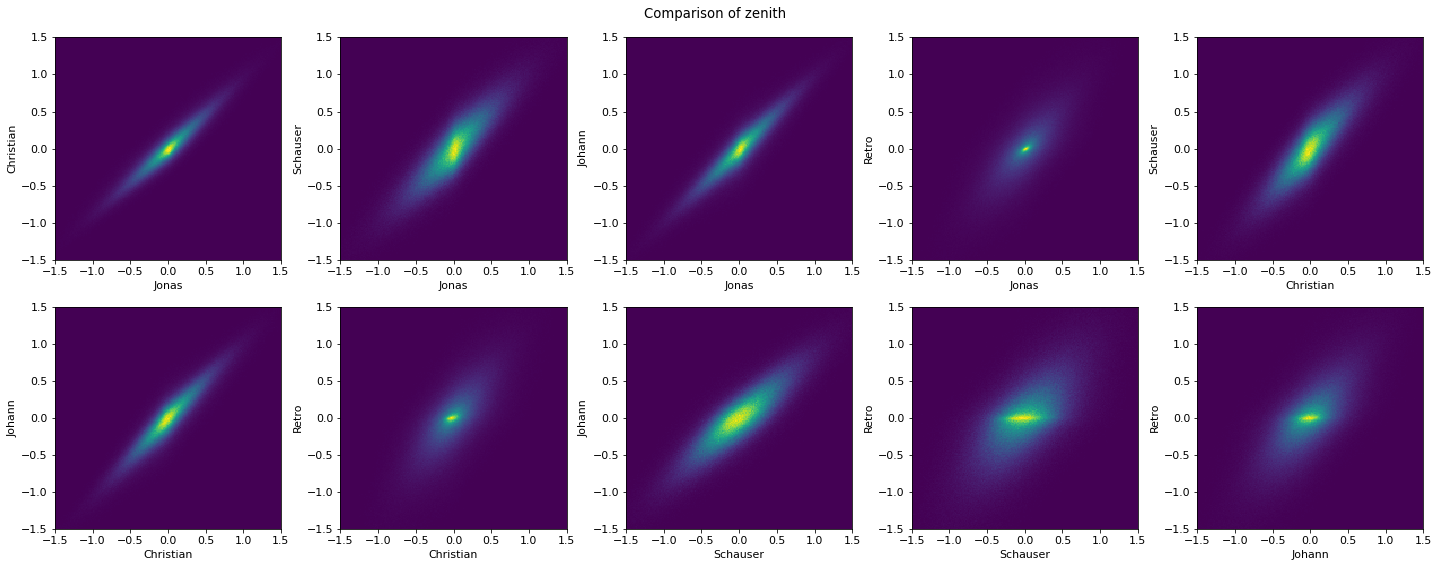

In [372]:
corr_plot(dfs, 'zenith', nc=5, nr=2, basesize=4, lim=1.5)

(<Figure size 1440x576 with 10 Axes>,
 array([[<AxesSubplot:xlabel='Jonas', ylabel='Christian'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Schauser'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Johann'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Retro'>,
         <AxesSubplot:xlabel='Christian', ylabel='Schauser'>],
        [<AxesSubplot:xlabel='Christian', ylabel='Johann'>,
         <AxesSubplot:xlabel='Christian', ylabel='Retro'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Johann'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Retro'>,
         <AxesSubplot:xlabel='Johann', ylabel='Retro'>]], dtype=object))

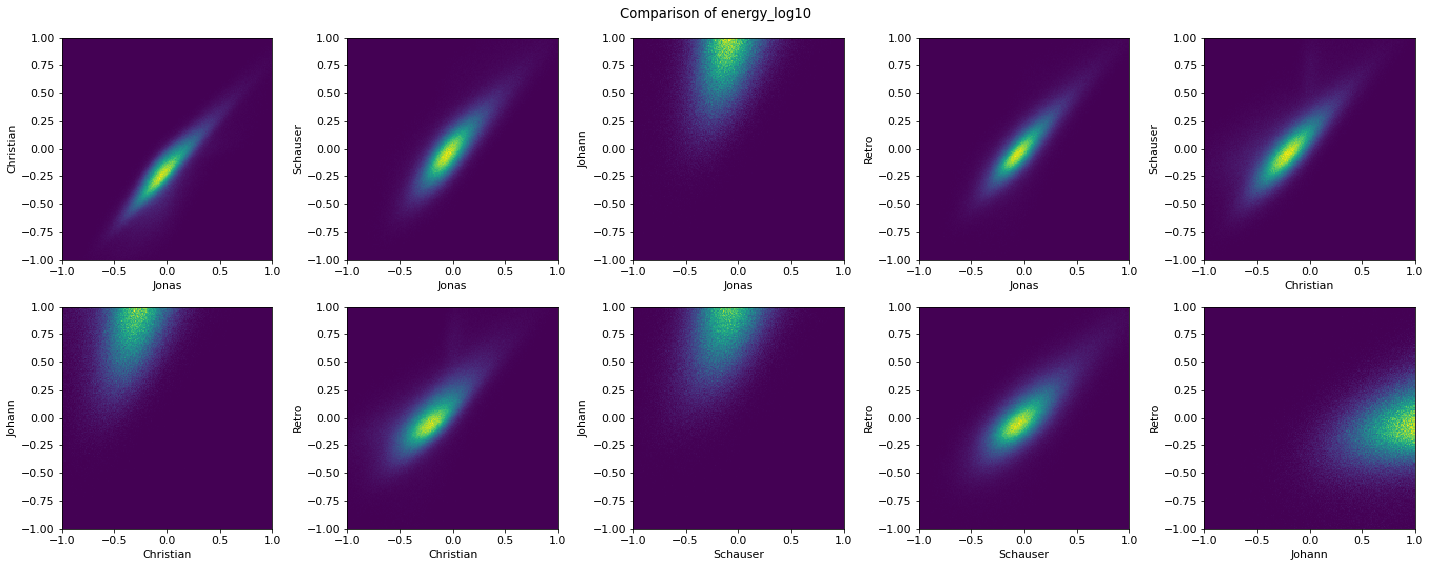

In [373]:
corr_plot(dfs, 'energy_log10', nc=5, nr=2, basesize=4, lim=1)

(<Figure size 1080x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Jonas', ylabel='Christian'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Schauser'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Johann'>],
        [<AxesSubplot:xlabel='Christian', ylabel='Schauser'>,
         <AxesSubplot:xlabel='Christian', ylabel='Johann'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Johann'>]], dtype=object))

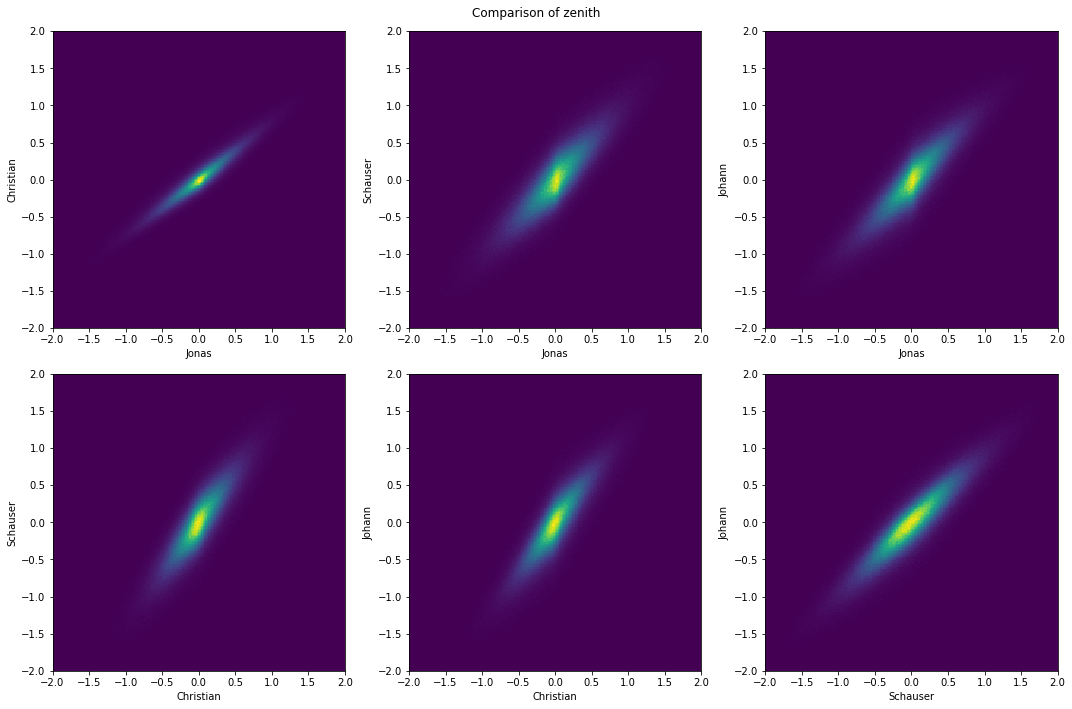

In [61]:
corr_plot(dfs[:4], 'zenith')

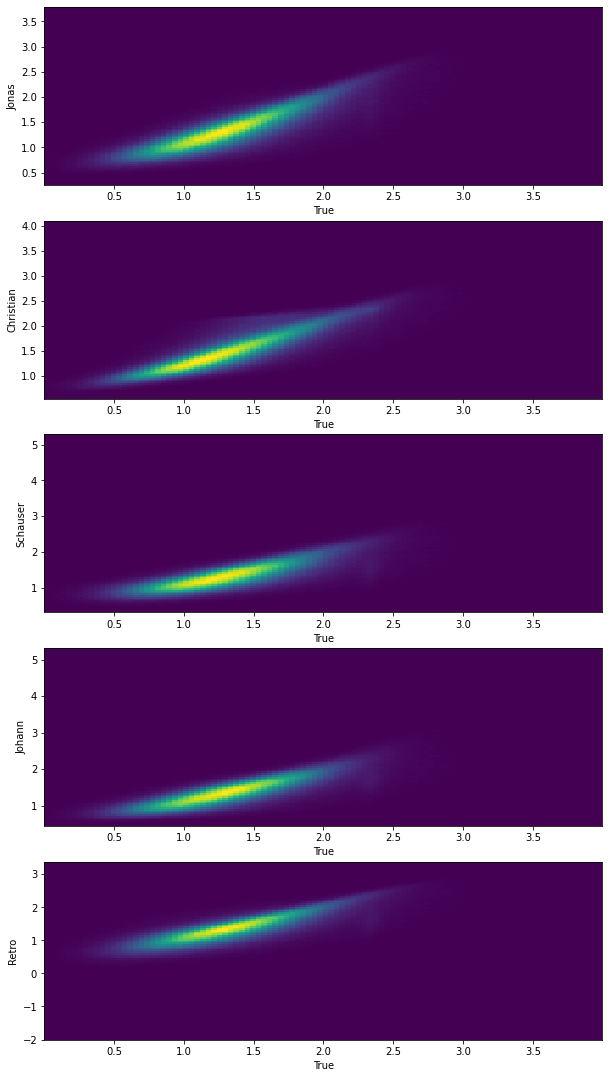

In [62]:
fig, ax =plt.subplots(nrows=5, figsize=(10,19))
for i in range(5):
    ax[i].hist2d(df_truth['energy_log10'], dfs[i]['energy_log10_pred'], bins=100)
    ax[i].set(xlabel='True', ylabel=names[i])

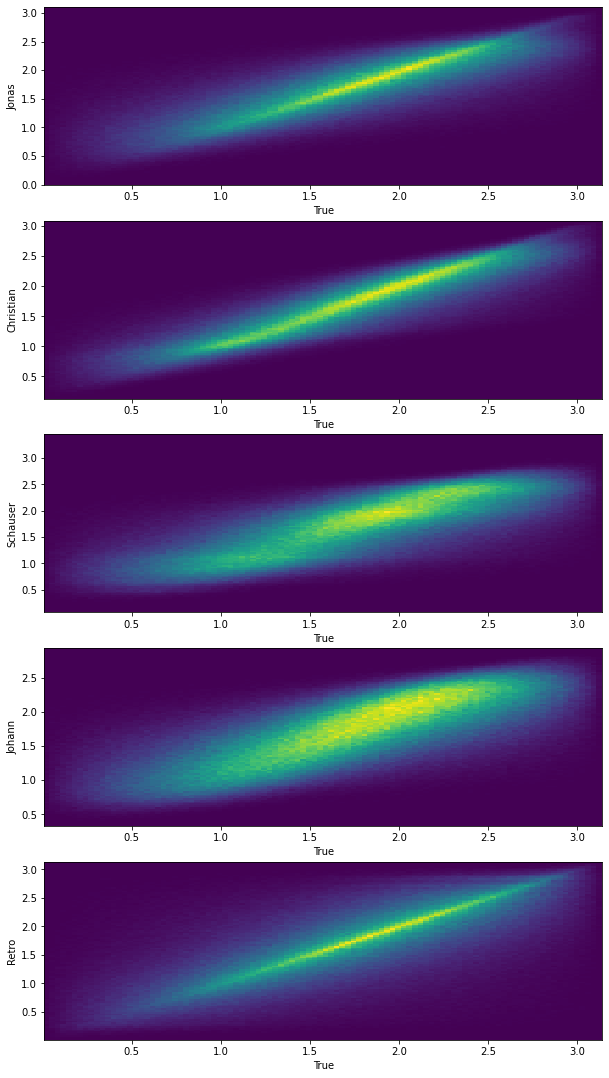

In [63]:
fig, ax =plt.subplots(nrows=5, figsize=(10,19))
for i in range(5):
    ax[i].hist2d(df_truth['zenith'], dfs[i]['zenith_pred'], bins=100)
    ax[i].set(xlabel='True', ylabel=names[i])

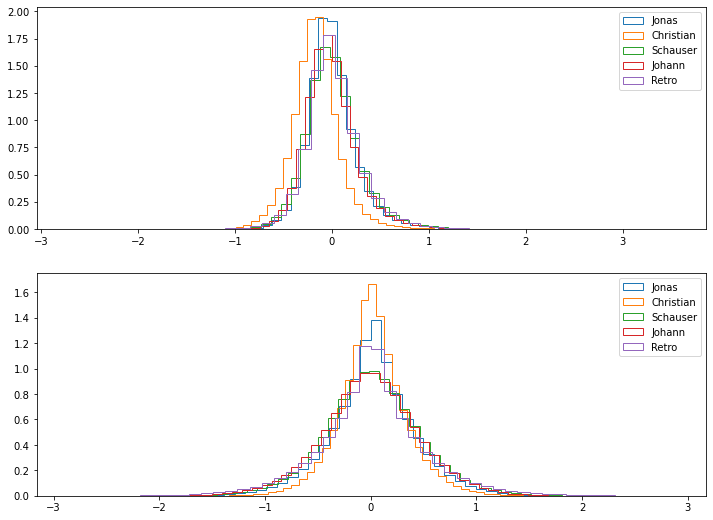

In [64]:
fig, ax=plt.subplots(2, figsize=(12,9))
bins=50
dens=1
for i in range(5):
    ax[0].hist(dfs[i]['energy_log10_res'], bins=bins, histtype='step',  density=dens, label=names[i])
    ax[1].hist(dfs[i]['zenith_res'], bins=bins, histtype='step',  density=dens, label=names[i])
    
# ax[0].hist(df_truth['energy_log10']-df_truth['energy_log10_retro'], bins=bins, histtype='step',  density=dens, label='Retro')
# ax[1].hist(df_truth['zenith']-df_truth['zenith_retro'], bins=bins, histtype='step',  density=dens, label='Retro')

ax[0].legend()
ax[1].legend()

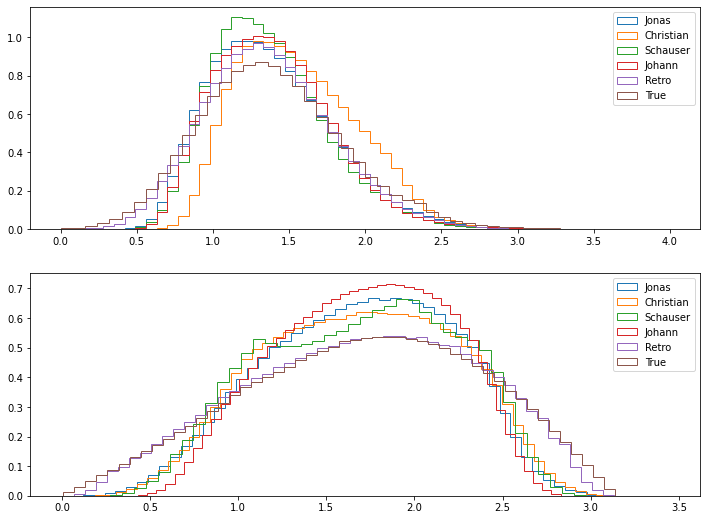

In [65]:
fig, ax=plt.subplots(2, figsize=(12,9))
bins=50
dens=1
for i in range(5):
    ax[0].hist(dfs[i]['energy_log10_pred'], bins=bins, range=(0,3.5), histtype='step',  density=dens, label=names[i])
    ax[1].hist(dfs[i]['zenith_pred'], bins=bins, histtype='step',  density=dens, label=names[i])
ax[0].hist(df_truth['energy_log10'], bins=bins, histtype='step',  density=dens, label='True')
ax[1].hist(df_truth['zenith'], bins=bins, histtype='step',  density=dens, label='True')
ax[0].legend()
ax[1].legend()

In [66]:
dfstats

,Unnamed: 0,event_no,n_strings,n_doms,cq_x,cq_y,cq_z
0,0,8,7.0,11,29.560598,-28.549552,-346.532387
1,1,10,7.0,16,60.860462,-58.746769,-388.543386
2,2,15,5.0,17,33.878788,-11.369393,-323.135152
3,3,29,3.0,9,103.089133,-87.221304,-439.446528
4,4,32,3.0,18,-2.941875,-80.715625,-303.853742
...,...,...,...,...,...,...,...
1658266,1658266,117104280,7.0,16,25.476153,30.214153,-319.356001
1658295,1658295,117104410,4.0,19,92.061704,-17.235106,-212.125110
1658296,1658296,117104424,6.0,21,49.674525,-111.003095,-230.398335
1658337,1658337,117104650,8.0,19,-16.869273,-78.887637,-293.396635


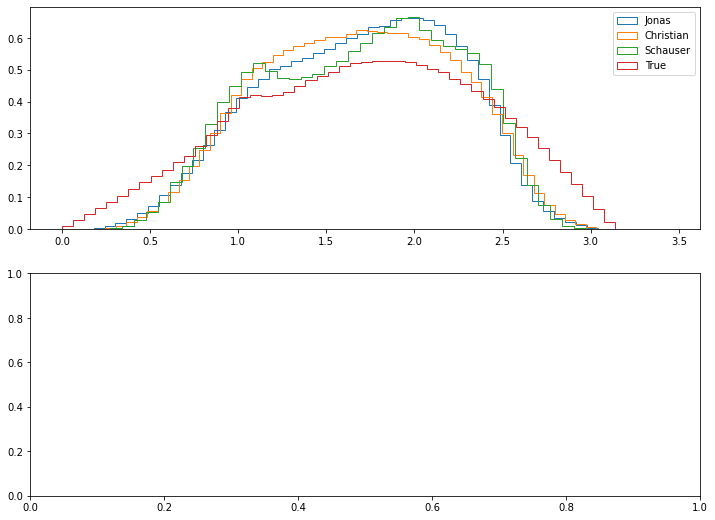

In [67]:
fig, ax=plt.subplots(2, figsize=(12,9))
bins=50
dens=1
for df,name in zip(dfs_ka[:3], names[:3]):
    ax[0].hist(df['zenith_pred'][(df['zenith_sig'] < np.percentile(df['zenith_sig'], 95))], bins=bins, histtype='step', label=name, density=dens)
ax[0].hist(dfckj['zenith'], bins=bins, histtype='step',  density=dens, label='True')
ax[0].legend()

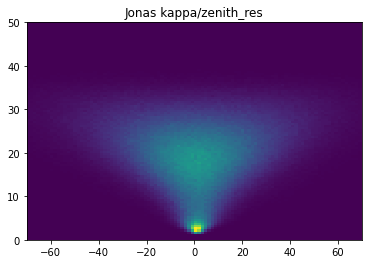

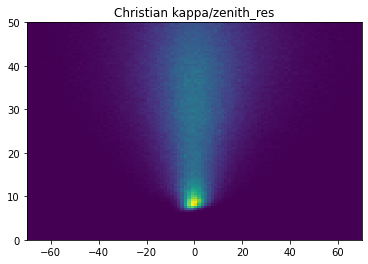

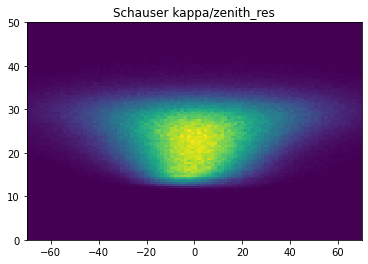

In [68]:
p=100
n=2
for n in range(3):
    fig, ax=plt.subplots()
    ax.hist2d((dfs[n][(dfs_ka[n]['zenith_sig'] < np.percentile(dfs_ka[n]['zenith_sig'], p))].zenith_res*180/np.pi)\
              , dfs_ka[n][(dfs_ka[n]['zenith_sig'] < np.percentile(dfs_ka[n]['zenith_sig'], p))].zenith_sig*180/np.pi,\
              bins=100, range=[[-70,70],[0,50]]);
    ax.set(title=names[n]+' kappa/zenith_res')

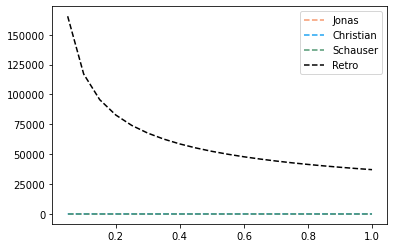

In [142]:
# n=2
facts=[1.06, 0.4, 1, 1]
for n in [0,1,2,3]:
    sig_run=[]
    for i in range(1,21):
        df_per=dfs_ka[n][(dfs_ka[n]['zenith_sig'] < np.percentile(dfs_ka[n]['zenith_sig'], i*5))]
        st=np.std(df_per['zenith_res']/(df_per['zenith_sig']*facts[n]+0.000001))
#         print(st)
        sig_run.append(st)
    if n==3:
        n+=1
    plt.plot(np.arange(1,21)/20, sig_run, label=names[n], c=colors[n], linestyle='dashed')
plt.legend()

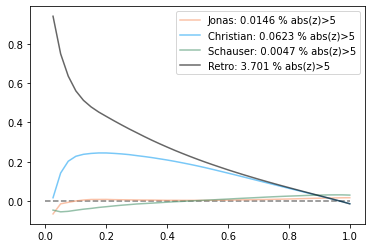

In [155]:
k=40
facts=[1.06, 0.4, 1, 2]
for n in [0,1,2, 3]:
    sig_run=[]
    for i in range(1,k+1):
        df_per=dfs_ka[n][(dfs_ka[n]['zenith_sig'] < np.percentile(dfs_ka[n]['zenith_sig'], i*2.5))]
        if i==k:
            a=len(df_per)
        df_per=df_per[abs(df_per['zenith_res']/(df_per['zenith_sig']*facts[n]+0.000001))<5]
        if i==k:
            b=len(df_per)
            c=a-b
        st=np.std(df_per['zenith_res']/(df_per['zenith_sig']*facts[n]+0.000001))
#         print(st)
        sig_run.append(st)
    if n==3:
        n+=1
    
    plt.plot(np.arange(1,k+1)/k, np.log(sig_run), label=names[n]+f': {np.round(c/a*100, 4)} % abs(z)>5', c=colors[n], linestyle='-', alpha=0.6)
plt.hlines(0,0,1, linestyle='dashed', color='gray')
plt.legend()

In [69]:
k=2
np.percentile(dfs[k]['zenith_sig'], 50)

0.43032088787415146

In [70]:
dfs_ka[k].describe()

,Unnamed: 0,event_no,energy_log10,energy_log10_pred,zenith,zenith_pred,zenith_kap,energy_log10_res,zenith_res,azimuth,zenith_sig
count,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06
mean,8.292034e+05,6.838142e+06,1.383190e+00,1.367347e+00,1.710938e+00,1.691082e+00,6.621666e+00,1.584300e-02,1.985595e-02,1.105748e-02,4.273600e-01
std,4.787434e+05,4.936352e+06,4.730510e-01,3.706447e-01,6.614248e-01,5.336108e-01,3.563810e+00,2.889600e-01,4.570937e-01,1.816777e+00,9.937942e-02
min,1.000000e+00,8.000000e+00,5.581535e-05,3.132948e-01,7.919154e-03,7.108688e-02,5.997890e-02,-2.251434e+00,-2.418280e+00,-3.141591e+00,1.606154e-01
25%,4.146005e+05,3.433202e+06,1.052147e+00,1.095444e+00,1.227602e+00,1.259685e+00,4.046726e+00,-1.645943e-01,-2.604917e-01,-1.561092e+00,3.510546e-01
50%,8.292340e+05,6.867563e+06,1.352626e+00,1.324560e+00,1.741449e+00,1.723782e+00,5.447040e+00,-1.032957e-02,1.210463e-02,1.739317e-02,4.303209e-01
75%,1.243862e+06,1.026266e+07,1.677530e+00,1.591662e+00,2.219668e+00,2.116480e+00,8.145241e+00,1.649945e-01,2.967789e-01,1.588990e+00,5.010837e-01
max,1.658362e+06,1.171047e+08,3.997173e+00,5.283747e+00,3.140002e+00,3.446488e+00,3.876534e+01,2.822831e+00,2.382580e+00,3.141592e+00,1.885388e+00


In [71]:
k=1
dfs_ka[k]['zenith_sig'].isnull().sum()

0

<AxesSubplot:>

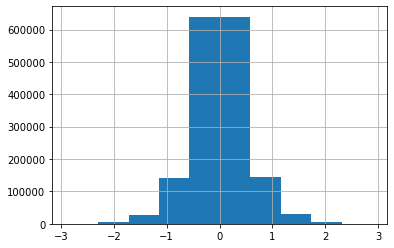

In [132]:
dfretro['zenith_res'].hist()

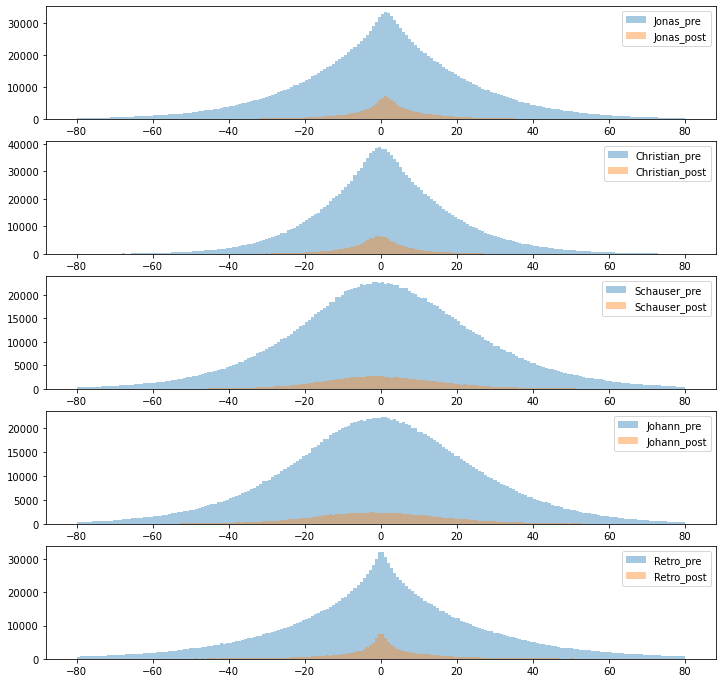

In [73]:
fig, ax=plt.subplots(5, figsize=(12,12))
bi=200
dens=0
ran=[-80,80]
for i in range(5):
    ax[i].hist(dfs[i][dfstats['n_strings'].to_numpy()>0].zenith_res*180/np.pi, alpha=0.4, bins=bi, density=dens, range=ran, label=names[i]+'_pre');
    ax[i].hist(dfs[i][dfstats['n_strings'].to_numpy()>10].zenith_res*180/np.pi, alpha=0.4, bins=bi, density=dens, range=ran, label=names[i]+'_post');
    ax[i].legend()

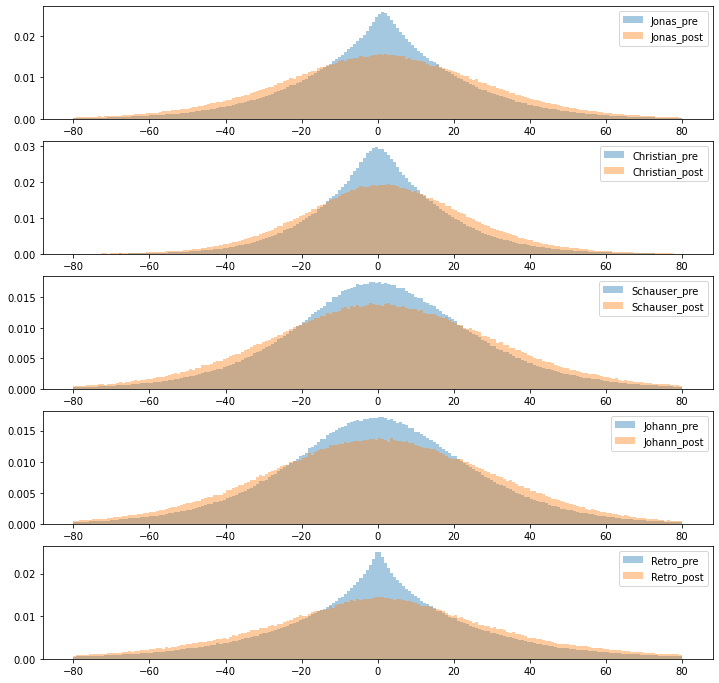

In [74]:
fig, ax=plt.subplots(5, figsize=(12,12))
bi=200
dens=1
for i in range(5):
    ax[i].hist(dfs[i][dfstats['n_doms'].to_numpy()>0].zenith_res*180/np.pi, alpha=0.4, bins=bi, range=ran, density=dens, label=names[i]+'_pre');
    ax[i].hist(dfs[i][dfstats['n_doms'].to_numpy()<15].zenith_res*180/np.pi, alpha=0.4, bins=bi, range=ran, density=dens, label=names[i]+'_post');
    ax[i].legend()

Text(0.5, 0.98, 'Distributions for more than median #doms compared to normal')

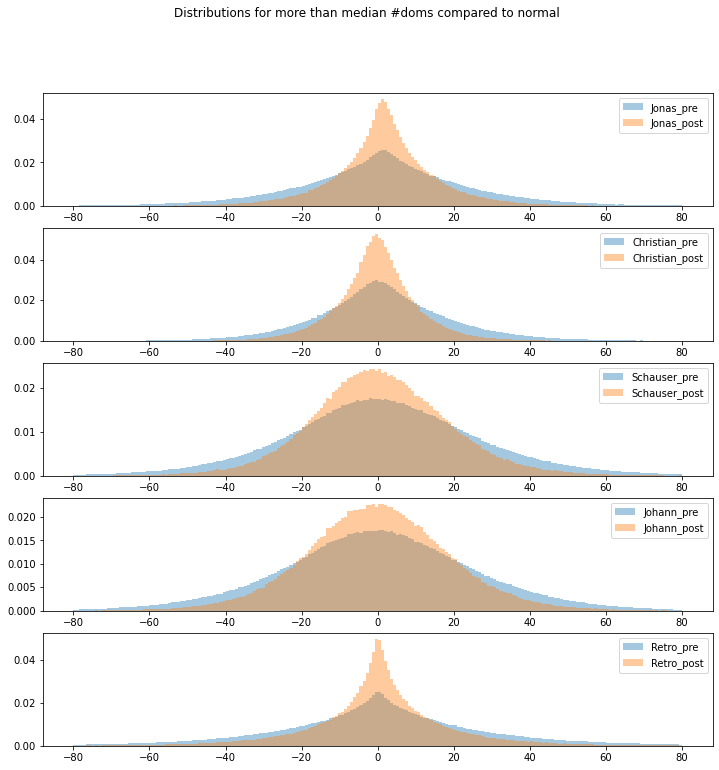

In [75]:
fig, ax=plt.subplots(5, figsize=(12,12))
bi=200
dens=1
for i in range(5):
    ax[i].hist(dfs[i][dfstats['n_doms'].to_numpy()>0].zenith_res*180/np.pi, alpha=0.4, bins=bi, range=ran, density=dens, label=names[i]+'_pre');
    ax[i].hist(dfs[i][dfstats['n_doms'].to_numpy()>28].zenith_res*180/np.pi, alpha=0.4, bins=bi, range=ran, density=dens, label=names[i]+'_post');
    ax[i].legend()
fig.suptitle('Distributions for more than median #doms compared to normal')

Text(0.5, 0.98, 'Distributions selected at -400 z compared to usual')

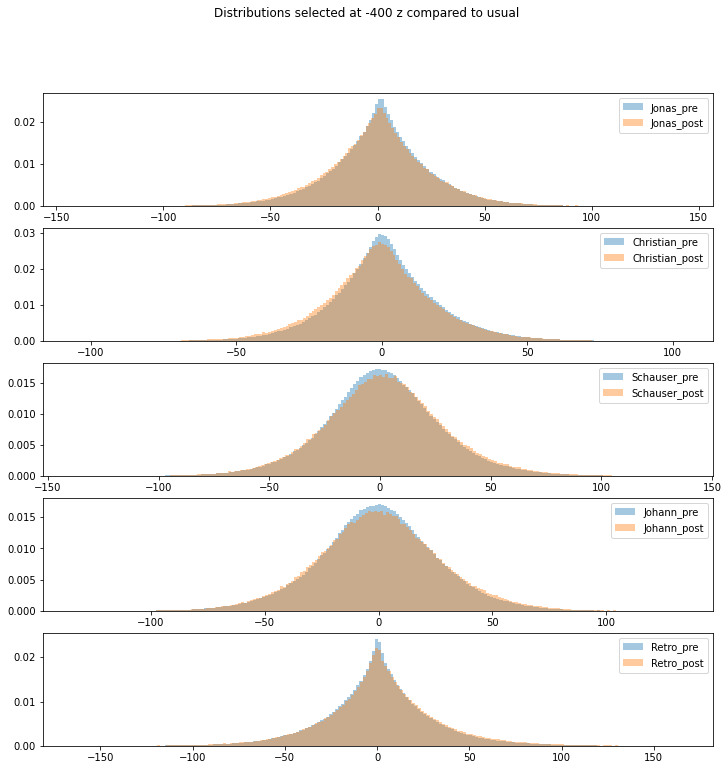

In [76]:
fig, ax=plt.subplots(5, figsize=(12,12))
bi=200
dens=1
for i in range(5):
    ax[i].hist(dfs[i].zenith_res*180/np.pi, alpha=0.4, bins=bi, density=dens, label=names[i]+'_pre');
    ax[i].hist(dfs[i][abs(dfstats['cq_z'].to_numpy())>400].zenith_res*180/np.pi, alpha=0.4, bins=bi, density=dens, label=names[i]+'_post');
    ax[i].legend()
fig.suptitle('Distributions selected at -400 z compared to usual')

<AxesSubplot:>

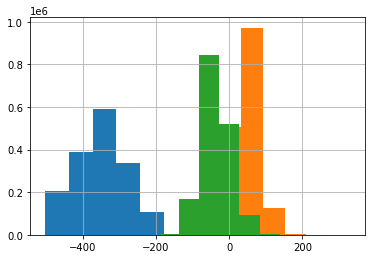

In [77]:
dfstats['cq_z'].hist()
dfstats['cq_x'].hist()
dfstats['cq_y'].hist()

In [78]:
dfstats.describe()

,Unnamed: 0,event_no,n_strings,n_doms,cq_x,cq_y,cq_z
count,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06,1.633027e+06
mean,8.165512e+05,6.838142e+06,6.289399e+00,2.631399e+01,4.839361e+01,-3.716726e+01,-3.501712e+02
std,4.714615e+05,4.936352e+06,2.801720e+00,2.976155e+01,3.292516e+01,3.909526e+01,6.714212e+01
min,0.000000e+00,8.000000e+00,1.000000e+00,8.000000e+00,-2.626905e+02,-3.029873e+02,-5.022790e+02
25%,4.082655e+05,3.433202e+06,4.000000e+00,1.200000e+01,2.642358e+01,-6.806314e+01,-4.058976e+02
50%,8.165310e+05,6.867563e+06,6.000000e+00,1.700000e+01,4.851335e+01,-4.362724e+01,-3.467073e+02
75%,1.224794e+06,1.026266e+07,8.000000e+00,2.800000e+01,7.044698e+01,-7.299478e+00,-3.035382e+02
max,1.658348e+06,1.171047e+08,3.000000e+01,1.067000e+03,3.297478e+02,2.488866e+02,1.446069e+02


In [79]:
def plot_quantiles(res, x, bins, qs, ax, label, color,offset):
    
    res=res.to_numpy()
    x=x.to_numpy()
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xes = np.zeros(bins)
    
    for i in range(bins):
        mask = (x >= slices[i])&(x <= slices[i+1])
        if mask.sum() != 0:
            quantiles[i] = np.quantile(res[mask],qs/100)
            xes[i] = np.mean(x[mask])
        else:
            print('whoops',i)
            quantiles[i] = None
            xes[i] = None
    
    xes += offset
    
    ax.errorbar(x = xes, y = quantiles[:,1], yerr = abs(quantiles[:,1] - quantiles[:,[0,2]].T),
                color=color,
                linewidth=5,
                alpha=0.5,
                capsize=5,
                linestyle='--',
                fmt='none')
    
    ax.plot(xes,quantiles[:,1],c=color,marker='*',label=label)
#     plt.grid()
    
    ax_hist = ax.twinx()
    val, binedges, _ = ax_hist.hist(x,bins=bins,histtype='step',color='grey',linewidth=5)
    ax_hist.vlines(xes-offset,val+0.1*val.mean(),val-0.1*val.mean(),color='grey',label='mean')
    ax_hist.set_ylim(0,ax_hist.get_ylim()[1])
    ax_hist.set_ylabel("N")
#     ax_hist.set_yscale('log')
    ax.set_zorder(ax_hist.get_zorder()+1)
    ax.patch.set_visible(False)

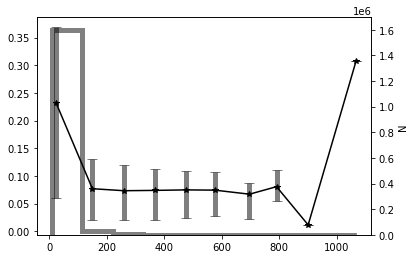

In [80]:
fig, ax=plt.subplots()
plot_quantiles(abs(dfs[0]['zenith_res']), dfstats['n_doms'], 10, np.array([16,50,68]), ax, 'hristian', 'k', 0)

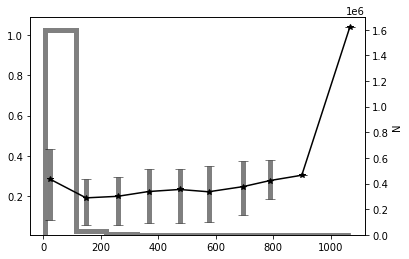

In [81]:
fig, ax=plt.subplots()
plot_quantiles(abs(dfs[3]['zenith_res']), dfstats['n_doms'], 10, np.array([16,50,68]), ax, 'hristian', 'k', 0)

In [82]:

colors=['#F7996E', '#20A4F3', '#519872', '#712F79', 'k', 'r']


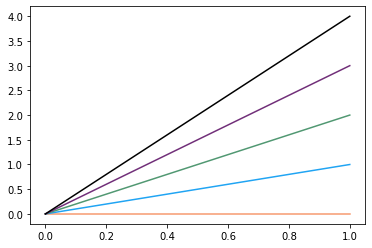

In [83]:
for i in range(5):
    plt.plot([0,i], c=colors[i])

In [84]:
def perc(dfs, res=True):
    return 1
    
def performance(dfs, names=names, offset=0, colors=colors, scale=180/np.pi, unit='degree', ran=[0,80], trueran=[0,180], ab=True, dfx=dfstats, y_param='zenith', logy=False, x_param='n_doms', bins=20, binhist=100, logx=True, qs=[16,50,68]):
    qs=np.array(qs)
    if logx:
        x=np.log(dfx[x_param].to_numpy())
    else:
        x=dfx[x_param].to_numpy()
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xs = np.zeros(bins)
    
    fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 5))
    axesback=[0]
    for i in axesback:
        a_ = ax[i].twinx()
        a_.hist(x, color = "gray", histtype='step', zorder = 10, alpha = 0.6)
        a_.set_yscale("log")
        if logx:
            ax[0].set_xlabel('log_'+x_param)
            a_.set_ylabel("N/"+'log('+x_param+')')
        else:
            a_.set_xlabel(x_param)
            ax[0].set_ylabel("N/"+x_param)

    for j in range(len(dfs)):
        res=dfs[j][y_param+'_res'].to_numpy()*scale
        if ab:
            res=abs(res)
        for i in tqdm(range(bins)):
            mask = (x >= slices[i])&(x <= slices[i+1])
            if mask.sum() != 0:
                quantiles[i] = np.quantile(res[mask],qs/100)
                xs[i] = np.mean(x[mask])
            else:
                print('whoops',i)
                quantiles[i] = None
                xs[i] = None
        
        ax[0].errorbar(xs+(j-len(dfs))*offset, quantiles[:,1],yerr = quantiles[:,[0,2]].T, fmt=colors[j], marker='.',\
                       capsize=2,linewidth=1,ecolor=colors[j],label=r'[16,50,68]'+'_'+names[j])
        if logx:
            ax[0].set_title(f'{y_param} as a function of log({x_param})')
        else:
            ax[0].set_title(f'{y_param} as a function of {x_param}')
        if logx:
            ax[0].set_ylabel(f'{y_param} median (16, 68)/log({y_param})')
        else:
            ax[0].set_ylabel(f'{y_param} median (16, 68)/{y_param}')
        ax[1].hist(res, label = y_param+'_res_'+names[j], color=colors[j], range=ran, histtype = "step", bins = binhist)
        ax[1].set(xlabel='Residuals'+f'({unit})', ylabel=f'N/{unit}', title='Residuals for '+y_param)
        ax[2].hist(dfs[j][y_param+'_pred']*scale, color=colors[j], range=trueran, histtype = "step", bins = binhist)
        ax[2].set(xlabel='Distribution'+f'({unit})', ylabel=f'N/{unit}', title='Distributions of '+y_param)
        if j==2:
            ax[2].hist(dfjbs[y_param]*scale, label = 'True', color='r', histtype = "step", bins = binhist)
#             ax[2].hist(df[y_param]*scale, label = 'True', color='r', histtype = "step", bins = binhist)
        if logy:
            ax[1].set(yscale='log')
            ax[2].set(yscale='log')
        for a in ax:
            a.legend()
    fig.suptitle(f'{y_param} analysis')
    fig.tight_layout()
    plt.savefig(f'../../figs_thesis/compare_{x_param}_{y_param}.pdf')
    return fig, ax

No handles with labels found to put in legend.


No handles with labels found to put in legend.


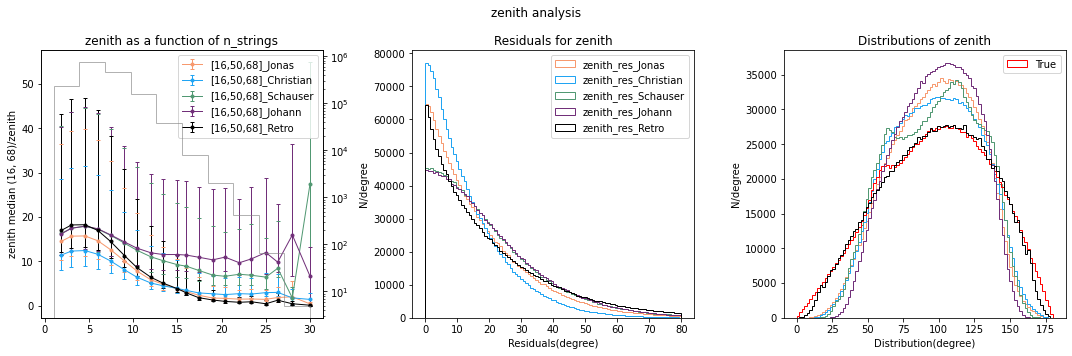

In [85]:
fig,ax=performance(dfs[:5], offset=0, logx=False, x_param='n_strings')

No handles with labels found to put in legend.


No handles with labels found to put in legend.


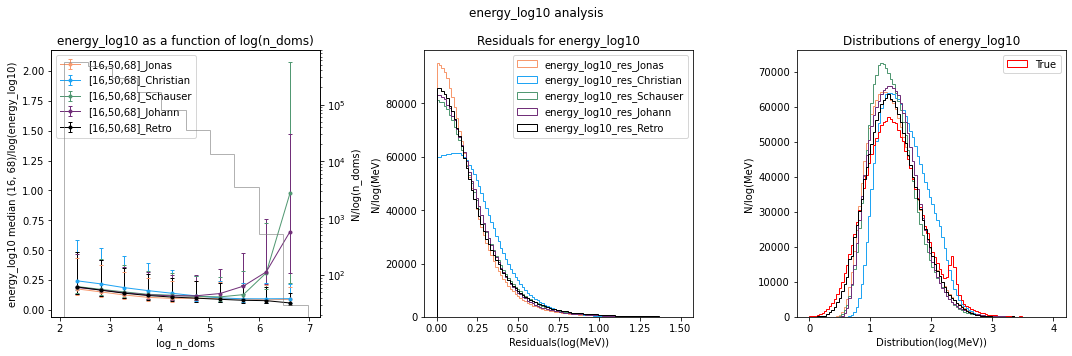

In [86]:
fig,ax=performance(dfs[:5], y_param='energy_log10', bins=10, x_param='n_doms', scale=1, logx=True, unit='log(MeV)', ran=[0,1.5], trueran=[0,4])

In [88]:
# sele=[0,1,2,4]
# performance(dfs[sele], names=names[sele], colors[sele], dfx=)

In [90]:
def performance_cuts(dfs, names=names, dfcuts=dfs, colors=colors, cut_param='zenith_sig', cutp=50, offset=0, scale=180/np.pi, unit='degree', ran=[0,80], trueran=[0,180], ab=True, dfx=dfstats, y_param='zenith', logy=False, x_param='n_doms', bins=20, binhist=100, logx=True, qs=[16,50,68]):
    qs=np.array(qs)
    if logx:
        x=np.log(dfx[x_param].to_numpy())
    else:
        x=dfx[x_param].to_numpy()
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xs = np.zeros(bins)
    
    fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 5))
    axesback=[0]
    for i in axesback:
        a_ = ax[i].twinx()
        a_.hist(x, color = "gray", histtype='step', zorder = 10, alpha = 0.6)
        a_.set_yscale("log")
        if logx:
            ax[0].set_xlabel('log_'+x_param)
            a_.set_ylabel("N/"+'log('+x_param+')')
        else:
            a_.set_xlabel(x_param)
            ax[0].set_ylabel("N/"+x_param)
    
    for j in range(len(dfs)):
        dfcuts[j][cut_param]
        maskcut=dfcuts[j][cut_param].to_numpy()<np.percentile(dfcuts[j][cut_param],[cutp])
        print(f'Cutting at {cut_param} {np.percentile(dfcuts[j][cut_param],[cutp])}')
        df=dfs[j][maskcut]
        x0=x[maskcut]
        res=df[y_param+'_res'].to_numpy()*scale
        if ab:
            res=abs(res)
        for i in tqdm(range(bins)):
            mask = (x0 >= slices[i])&(x0 <= slices[i+1])
            if mask.sum() != 0:
                quantiles[i] = np.quantile(res[mask],qs/100)
                xs[i] = np.mean(x0[mask])
            else:
                print('whoops',i)
                quantiles[i] = None
                xs[i] = None
        
        ax[0].errorbar(xs+(j-len(dfs))*offset, quantiles[:,1],yerr = quantiles[:,[0,2]].T, fmt=colors[j], marker='.',\
                       capsize=2,linewidth=1,ecolor=colors[j],label=r'[16,50,68]'+'_'+names[j])
        if logx:
            ax[0].set_title(f'{y_param} as a function of log({x_param})')
        else:
            ax[0].set_title(f'{y_param} as a function of {x_param}')
        if logx:
            ax[0].set_ylabel(f'{y_param} median (16, 68)/log({y_param})')
        else:
            ax[0].set_ylabel(f'{y_param} median (16, 68)/{y_param}')
        ax[1].hist(res, label = y_param+'_res_'+names[j], color=colors[j], range=ran, histtype = "step", bins = binhist)
        ax[1].set(xlabel='Residuals'+f'({unit})', ylabel=f'N/{unit}', title='Residuals for '+y_param)
        ax[2].hist(df[y_param+'_pred']*scale, color=colors[j], range=trueran, histtype = "step", bins = binhist)
        ax[2].set(xlabel='Distribution'+f'({unit})', ylabel=f'N/{unit}', title='Distributions of '+y_param)
        if j==0:
            ax[2].hist(dfs[j][y_param]*scale, label = 'True', color='r', histtype = "step", bins = binhist)
        if logy:
            ax[1].set(yscale='log')
            ax[2].set(yscale='log')
        for a in ax:
            a.legend()
    fig.suptitle(f'{y_param} analysis with {cut_param} cut')
    fig.tight_layout()
    plt.savefig(f'../../figs_thesis/compare_{x_param}_{y_param}_cut_{cut_param}_{cutp}.pdf')
    return fig, ax

Cutting at zenith_sig [0.36070742]



Cutting at zenith_sig [0.91162231]



Cutting at zenith_sig [0.43032089]



Cutting at zenith_sig [0.2986238]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of log(n_doms)'}, xlabel='log_n_doms', ylabel='zenith median (16, 68)/log(zenith)'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

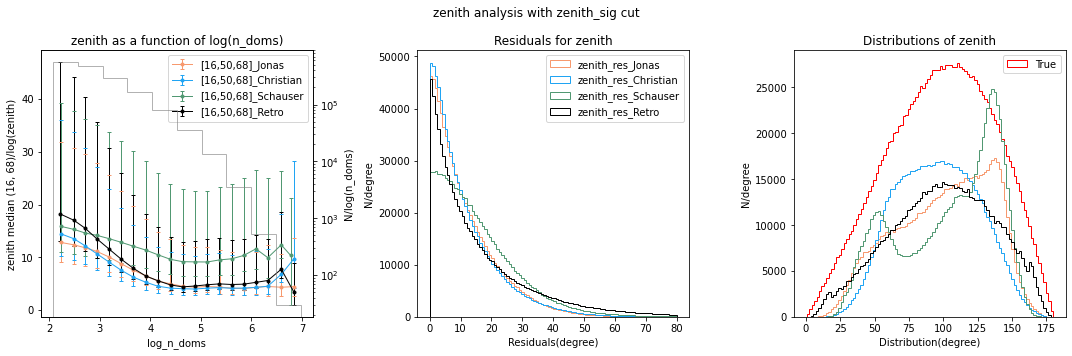

In [91]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], dfx=dfstats,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]])

Cutting at zenith_sig [0.36070742]



Cutting at zenith_sig [0.91162231]



Cutting at zenith_sig [0.43032089]



Cutting at zenith_sig [0.2986238]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of n_strings'}, ylabel='zenith median (16, 68)/zenith'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

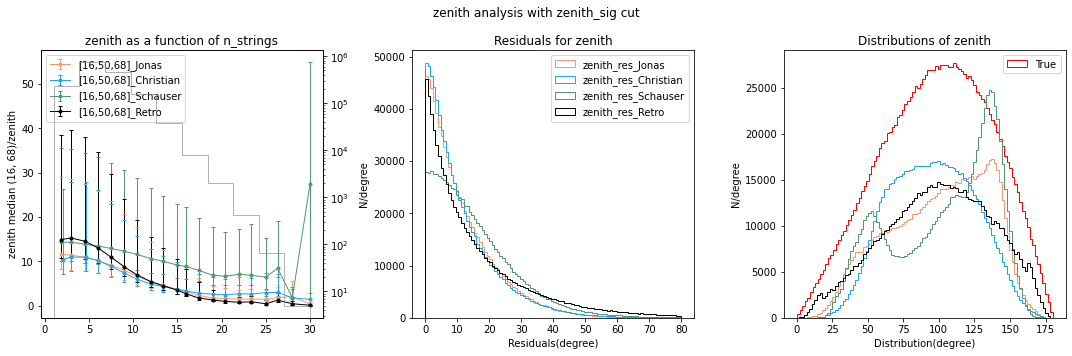

In [92]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], logx=False, x_param='n_strings',dfx=dfstats,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]])

Cutting at zenith_sig [0.16766521]


whoops 0

Cutting at zenith_sig [0.35472054]


whoops 0
whoops 1

Cutting at zenith_sig [0.29025556]


whoops 0

Cutting at zenith_sig [0.07513809]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of energy_log10'}, ylabel='zenith median (16, 68)/zenith'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

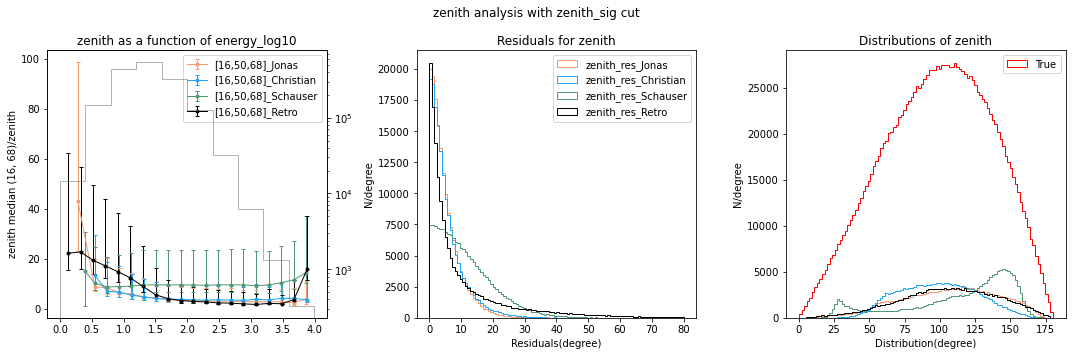

In [93]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], logx=False, x_param='energy_log10',
                 dfx=df_truth,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]], cutp=10)

Cutting at zenith_sig [0.36070742]



Cutting at zenith_sig [0.91162231]



Cutting at zenith_sig [0.43032089]



Cutting at zenith_sig [0.2986238]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of zenith'}, ylabel='zenith median (16, 68)/zenith'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

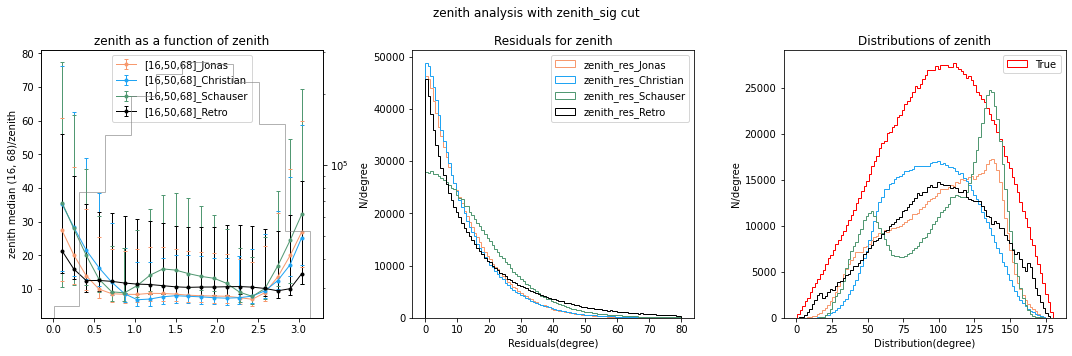

In [94]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], logx=False, x_param='zenith',
                 dfx=df_truth,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]])

Cutting at zenith_sig [0.36070742]



Cutting at zenith_sig [0.91162231]



Cutting at zenith_sig [0.43032089]



Cutting at zenith_sig [0.2986238]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of zenith'}, ylabel='zenith median (16, 68)/zenith'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

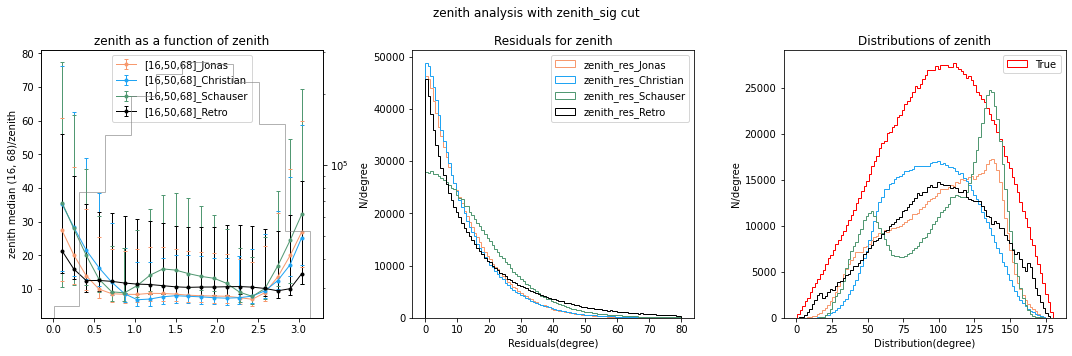

In [95]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], logx=False, x_param='zenith',
                 dfx=df_truth,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]])

No handles with labels found to put in legend.


No handles with labels found to put in legend.


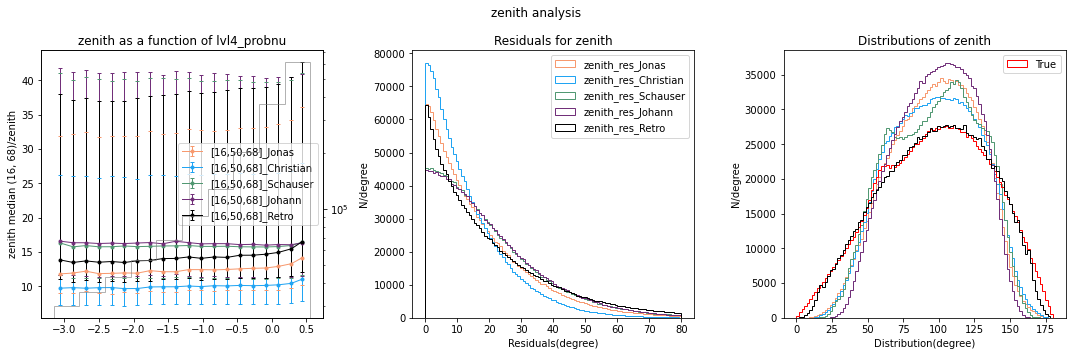

In [96]:
fig,ax=performance(dfs[:5], y_param='zenith', bins=20, x_param='lvl4_probnu', logx=0, dfx=df_truth)

whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9


No handles with labels found to put in legend.


whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9


No handles with labels found to put in legend.


whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9



whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9



whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9



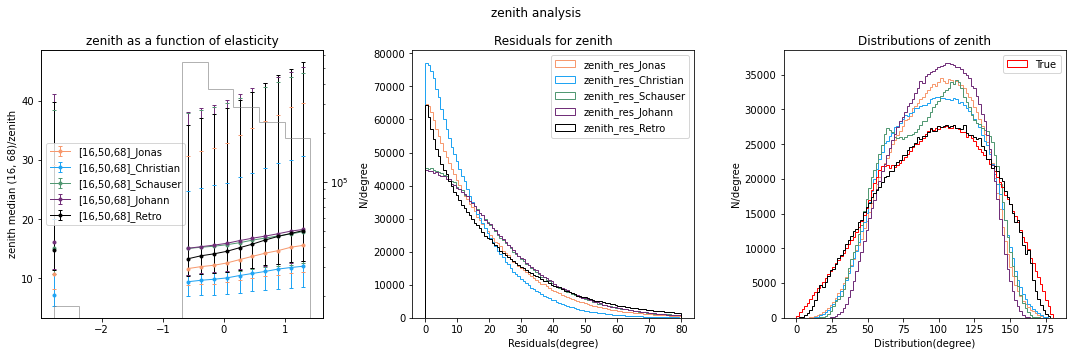

In [97]:
fig,ax=performance(dfs[:5], y_param='zenith', bins=20, x_param='elasticity', logx=0, dfx=df_truth)

<AxesSubplot:>

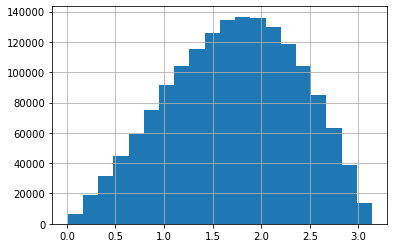

In [98]:
df_truth['zenith'].hist(bins=20)

<AxesSubplot:>

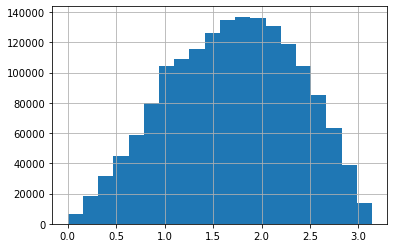

In [99]:
dfjs['zenith'].hist(bins=20)

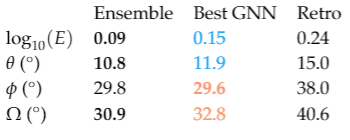

In [611]:
(0.24-0.09)/0.24*100, (15.0-10.8)/15*100,(38.0-29.8)/38*100, (40.6-30.9)/40.6*100

(62.5, 27.999999999999996, 21.57894736842105, 23.891625615763555)

In [612]:
(0.24-0.15)/0.24*100, (15.0-11.9)/15*100,(38.0-29.6)/38*100, (40.6-32.8)/40.6*100

(37.5, 20.666666666666664, 22.105263157894733, 19.211822660098534)